In [196]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import polars as pl

import plotly.io as pio

In [ ]:
## This notebook is a small experiment to test out different momentum settings using parametric experiment

In [154]:
nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

# Generate data using Polars
# Create DataFrames for each cluster
a_df = pl.DataFrame({
    'x': A[0] + np.random.randn(nPerClust) * blur,
    'y': A[1] + np.random.randn(nPerClust) * blur,
    'label': [0] * nPerClust
})

b_df = pl.DataFrame({
    'x': B[0] + np.random.randn(nPerClust) * blur,
    'y': B[1] + np.random.randn(nPerClust) * blur,
    'label': [1] * nPerClust
})

c_df = pl.DataFrame({
    'x': C[0] + np.random.randn(nPerClust) * blur,
    'y': C[1] + np.random.randn(nPerClust) * blur,
    'label': [2] * nPerClust
})

# Concatenate into a single DataFrame
all_data = pl.concat([a_df, b_df, c_df])

In [155]:
# inspect the data
print(all_data)

shape: (900, 3)
┌───────────┬───────────┬───────┐
│ x         ┆ y         ┆ label │
│ ---       ┆ ---       ┆ ---   │
│ f64       ┆ f64       ┆ i64   │
╞═══════════╪═══════════╪═══════╡
│ -0.811585 ┆ 0.787128  ┆ 0     │
│ 3.147399  ┆ -0.274099 ┆ 0     │
│ 1.722471  ┆ 1.143158  ┆ 0     │
│ 1.262746  ┆ 0.237306  ┆ 0     │
│ 4.62133   ┆ 1.016236  ┆ 0     │
│ …         ┆ …         ┆ …     │
│ 3.621568  ┆ 5.666419  ┆ 2     │
│ 4.525747  ┆ 3.827036  ┆ 2     │
│ 3.74326   ┆ 5.055655  ┆ 2     │
│ 3.412779  ┆ 4.84776   ┆ 2     │
│ 4.720874  ┆ 2.315833  ┆ 2     │
└───────────┴───────────┴───────┘


In [156]:
# create the class model
class ANN(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(2, 8)
        self.hidden1 = nn.Linear(8, 8)
        self.output = nn.Linear(8, 3)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        return self.output(x)

In [157]:
model = ANN()

# confirm that the optimizer has momentum
torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [158]:
# training the model
def trainModel(train_loader, test_loader, momentum, numepochs=200, learning_rate=0.01):
    # define the dataframe
    training_progress = pl.DataFrame(
        schema={
            'iteration' : pl.Int64,
            'epoch' : pl.Int64,
            'train_loss' : pl.Float64,
            'test_loss' : pl.Float64,
            'train_acc' : pl.Float64,
            'test_acc' : pl.Float64
        }
    )


    # create a new model
    model = ANN()
    # create the other componenets
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    lossfunc = nn.CrossEntropyLoss()
    iteration = 0

    for epoch in range(numepochs):
        model.train()
        for X, y in train_loader:
            yhat_train = model(X)
            loss_train = lossfunc(yhat_train, y)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            # get the accuracy
            matches = torch.argmax(yhat_train, axis=1) == y
            matchesNumeric = matches.float()
            acc_train = 100 * torch.mean(matchesNumeric)

            # switch to evaluation
            model.eval()
            X_test, y_test= next(iter(test_loader))
            with torch.no_grad():
                yhat_test = model(X_test)
                loss_test = lossfunc(yhat_test, y_test)

            # get the test accuracy
            acc_test = 100 * torch.mean((torch.argmax(yhat_test, axis=1) == y_test).float())

            # switch back model training
            model.train()

            # add into a value
            new_row = pl.DataFrame([{
                'iteration' : iteration,
                'epoch' : epoch,
                'train_loss' : loss_train.item(),
                'test_loss' : loss_test.item(),
                'train_acc' : acc_train.item(),
                'test_acc' : acc_test.item()
            }])

            training_progress = pl.concat([training_progress, new_row])

            # move the iteration count up
            iteration += 1
    return  training_progress


In [159]:
# Prepare the data
## convert to tensor data
dataT = torch.tensor(all_data.select('x', 'y').to_numpy()).float()
labelT = torch.tensor(all_data['label'].to_numpy()).long()


In [160]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(dataT, labelT)

# convert to Pytorch DataSet
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# load into dataloader
batchSize = 16
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [161]:
momenta = [0, 0.5, 0.9, 0.95, 0.999]
all_results = []
for idx, mom in enumerate(momenta):
    print(f'Training with momentum = {mom}')
    training_progress = trainModel(momentum=mom, train_loader=train_loader, test_loader=test_loader, )
    # annotate the momenta used
    training_progress = training_progress.with_columns(momentum=pl.lit(mom).cast(pl.Float64))

    all_results.append(training_progress)

combined_results = pl.concat(all_results)

Training with momentum = 0
Training with momentum = 0.5
Training with momentum = 0.9
Training with momentum = 0.95
Training with momentum = 0.999


In [162]:
combined_results.select(pl.col('momentum').n_unique())

momentum
u32
5


In [167]:
combined_results

iteration,epoch,train_loss,test_loss,train_acc,test_acc,momentum
i64,i64,f64,f64,f64,f64,f64
0,0,1.15184,1.140896,37.5,29.333332,0.0
1,0,1.175146,1.136537,25.0,29.333332,0.0
2,0,1.123524,1.133411,31.25,29.333332,0.0
3,0,1.100474,1.130658,37.5,29.333332,0.0
4,0,1.101426,1.128295,43.75,29.333332,0.0
…,…,…,…,…,…,…
8395,199,1.140493,1.086021,25.0,31.111113,0.999
8396,199,1.060921,1.084869,25.0,31.111113,0.999
8397,199,1.163269,1.083323,18.75,31.111113,0.999


In [168]:
# groupby analysis by epoch and momenta
grouped_results = (
    combined_results
    .group_by('momentum', 'epoch')
    .agg(
    pl.all().exclude(['momentum', 'epoch']).mean().name.suffix('_mean')
    )
    .sort(['momentum', 'epoch'], descending=True)
    .with_columns(
        pl.col('momentum').cast(pl.Float64)
    )
)


In [173]:
grouped_results.select(pl.all())

momentum,epoch,iteration_mean,train_loss_mean,test_loss_mean,train_acc_mean,test_acc_mean
f64,i64,f64,f64,f64,f64,f64
0.999,199,8378.5,1.077831,1.073168,34.672619,33.777778
0.999,198,8336.5,1.073318,1.049905,36.160714,39.132276
0.999,197,8294.5,1.068606,1.060226,34.22619,33.523811
0.999,196,8252.5,1.067153,1.061814,36.160714,35.999999
0.999,195,8210.5,1.072519,1.052187,36.458333,39.291007
…,…,…,…,…,…,…
0.0,4,188.5,0.919164,0.893894,63.095238,59.703704
0.0,3,146.5,0.94553,0.92244,61.755952,60.116402
0.0,2,104.5,0.976928,0.956084,50.892857,52.88889


In [179]:
grouped_results.select(pl.col('momentum').cast(pl.String)).to_series()

momentum
str
"""0.999"""
"""0.999"""
"""0.999"""
"""0.999"""
"""0.999"""
…
"""0.0"""
"""0.0"""
"""0.0"""


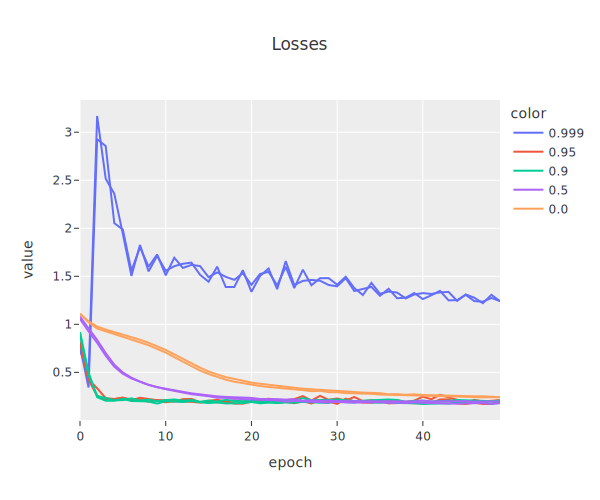

In [197]:
import plotly.express as px
fig = px.line(
    grouped_results.filter(pl.col('epoch') < 50),
    x='epoch',
    y=['train_loss_mean', 'test_loss_mean'],
    color=grouped_results.filter(pl.col('epoch') < 50).select(pl.col('momentum').cast(pl.String)).to_series(),
    title='Losses'
)

fig.update_layout(template='ggplot2', width=600)
fig.show(renderer='svg')

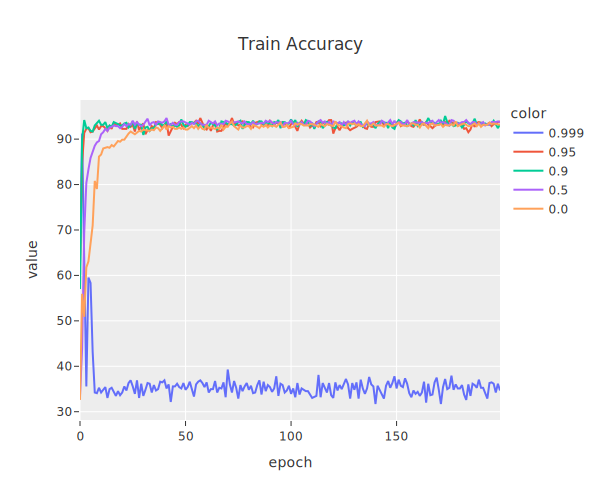

In [198]:
fig = px.line(
    grouped_results,
    x='epoch',
    y=['train_acc_mean', ],
    color=grouped_results.select(pl.col('momentum').cast(pl.String)).to_series(),
    title='Train Accuracy'
)

fig.update_layout(template='ggplot2', width=600)
fig.show(renderer='svg')

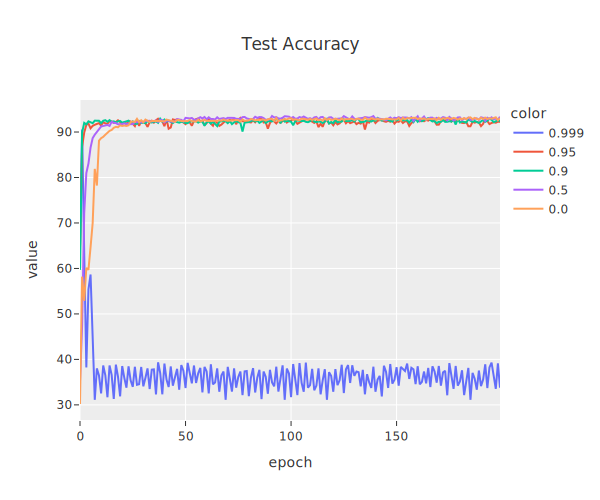

In [199]:
fig = px.line(
    grouped_results,
    x='epoch',
    y=['test_acc_mean'],
    color=grouped_results.select(pl.col('momentum').cast(pl.String)).to_series(),
    title='Test Accuracy'
)

fig.update_layout(template='ggplot2', width=600)
fig.show(renderer='svg')

# interpretation
* no momentum is a little slower
* with some momentum is learning much faster, until when the beta is large 0.999